In [21]:
import numpy as np
import mne, glob

In [22]:
all_file_path = glob.glob('BCICIV 2a/*.gdf')
print(len(all_file_path))

18


In [23]:
train_file_path = [i for i in all_file_path if 'T' in i.split('\\', 1)[-1]]
eval_file_path = [i for i in all_file_path if 'E' in i.split('\\', 1)[-1]]
print(len(train_file_path),len(eval_file_path))

9 9


In [24]:
# set the function of data generating and filterring
def read_data(file_path):
    data = mne.io.read_raw_gdf(file_path, preload = True)
    data.set_eeg_reference()
    data.filter(0.5, 100, method='iir')
    # Set EOG channel types
    eog_channels = ['EOG-left', 'EOG-central', 'EOG-right']
    for ch_name in eog_channels:
        if ch_name in data.ch_names:
            data.set_channel_types({ch_name: 'eog'})

    # Pick EEG and EOG channels
    picks = mne.pick_types(data.info, meg=False, eeg=True, eog=False, stim=False,
                       exclude=[])
    events, event_id = mne.events_from_annotations(data)
    selected_event_labels = ['769', '770', '771', '772']
    selected_event_id = {label: event_id[label] for label in selected_event_labels}

    # Filter the events array
    selected_events = events[np.isin(events[:, 2], list(selected_event_id.values()))]
    # Read epochs
    epochs = mne.Epochs(data, selected_events, selected_event_id, tmin = -0., tmax = 1, proj=False, 
                    picks=picks, baseline=None, preload=True, verbose=False)
    labels = epochs.events[:, -1]
    # extract raw data. scale by 1000 due to scaling sensitivity in deep learning
    X = epochs.get_data()*1000 # format is in (trials, channels, samples)
    Y = labels
    return X
def read_labels(file_path):
    data = mne.io.read_raw_gdf(file_path, preload = True)
    data.set_eeg_reference()
    data.filter(0.5, 100, method='iir')
    # Set EOG channel types
    eog_channels = ['EOG-left', 'EOG-central', 'EOG-right']
    for ch_name in eog_channels:
        if ch_name in data.ch_names:
            data.set_channel_types({ch_name: 'eog'})

    # Pick EEG and EOG channels
    picks = mne.pick_types(data.info, meg=False, eeg=True, eog=False, stim=False,
                       exclude=[])
    events, event_id = mne.events_from_annotations(data)
    selected_event_labels = ['769', '770', '771', '772']
    selected_event_id = {label: event_id[label] for label in selected_event_labels}

    # Filter the events array
    selected_events = events[np.isin(events[:, 2], list(selected_event_id.values()))]
    # Read epochs
    epochs = mne.Epochs(data, selected_events, selected_event_id, tmin = -0., tmax = 1, proj=False, 
                    picks=picks, baseline=None, preload=True, verbose=False)
    labels = epochs.events[:, -1]
    # extract raw data. scale by 1000 due to scaling sensitivity in deep learning
    X = epochs.get_data()*1000 # format is in (trials, channels, samples)
    Y = labels
    Y -= 6
    return Y

In [25]:
X = read_data(train_file_path[0])
Y = read_labels(train_file_path[0])

Extracting EDF parameters from /Users/mitchell/Downloads/Trained Models/BCICIV 2a/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/Users/mitchell/anaconda3/envs/bci_test/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 100.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Extracting EDF parameters from /Users/mitchell/Downloads/Trained Models/BCICIV 2a/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690

/Users/mitchell/anaconda3/envs/bci_test/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 100.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']


In [26]:
Y.shape

(288,)

In [27]:
chans, samples = 22, 251

In [28]:
# take 50/25/25 percent of the data to train/validate/test
X_train      = X[0:144,]
Y_train      = Y[0:144]
X_validate   = X[144:216,]
Y_validate   = Y[144:216]
X_test       = X[216:,]
Y_test       = Y[216:]

In [29]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# convert labels to one-hot encodings.
Y_train      = to_categorical(Y_train-1)
Y_validate   = to_categorical(Y_validate-1)
Y_test       = to_categorical(Y_test-1)

In [30]:
# convert data to NHWC (trials, channels, samples, kernels) format. Data 
# contains 22 channels and 251 time-points.
X_train      = X_train.reshape(X_train.shape[0], chans, samples)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples)
X_test       = X_test.reshape(X_test.shape[0], chans, samples)

In [31]:
print('X_train shape:', X_train.shape)
print(X_train[0])
print(X_test.shape[0], 'test samples')

X_train shape: (144, 22, 251)
[[ 0.00718636  0.00910629  0.01217317 ... -0.00546961 -0.005243
  -0.00408977]
 [ 0.00182106  0.00303724  0.00355259 ... -0.00215978 -0.00515362
  -0.00557592]
 [ 0.00220968  0.004249    0.00623719 ... -0.0064771  -0.006795
  -0.00680417]
 ...
 [ 0.00065093 -0.00138428 -0.00151616 ...  0.00540202  0.00486136
   0.001413  ]
 [ 0.00084465 -0.00178895 -0.00325722 ...  0.00542044  0.00592322
   0.0026308 ]
 [ 0.00387408  0.00077742  0.00087902 ...  0.00820446  0.0104787
   0.00535328]]
72 test samples


In [32]:
import numpy as np

# mne imports
import mne
from mne import io
from mne.datasets import sample

# EEGNet-specific imports
from CNNModels import ShallowConvNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

# PyRiemann imports
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.utils.viz import plot_confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# tools for plotting confusion matrices
from matplotlib import pyplot as plt

In [33]:
# configure the ShallowConvNet
model = ShallowConvNet(nb_classes = 4, Chans = chans, Samples = samples, 
               dropoutRate = 0.5)

2023-05-27 15:20:00.057335: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [34]:
# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])

In [35]:
# load optimal weights
model.load_weights('./shallow model/checkpoint_SC.h5')

In [36]:
# count number of parameters in the model
numParams    = model.count_params()    

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint_SC.h5', verbose=1,
                               save_best_only=True)

In [37]:
# the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
# the weights all to be 1
class_weights = {0:1, 1:1, 2:1, 3:1}

In [38]:
# The config of ShallowConvNet Model training details
fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = 300, 
                        verbose = 2, validation_data=(X_validate, Y_validate),
                        callbacks=[checkpointer], class_weight = class_weights)

Epoch 1/300

Epoch 1: val_loss improved from inf to 3.73417, saving model to /tmp/checkpoint_SC.h5
9/9 - 1s - loss: 0.0069 - accuracy: 1.0000 - val_loss: 3.7342 - val_accuracy: 0.2778 - 789ms/epoch - 88ms/step
Epoch 2/300

Epoch 2: val_loss did not improve from 3.73417
9/9 - 0s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 3.7656 - val_accuracy: 0.2639 - 158ms/epoch - 18ms/step
Epoch 3/300

Epoch 3: val_loss improved from 3.73417 to 3.57619, saving model to /tmp/checkpoint_SC.h5
9/9 - 0s - loss: 0.0062 - accuracy: 1.0000 - val_loss: 3.5762 - val_accuracy: 0.2500 - 182ms/epoch - 20ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 3.57619
9/9 - 0s - loss: 0.0050 - accuracy: 1.0000 - val_loss: 4.0770 - val_accuracy: 0.2778 - 163ms/epoch - 18ms/step
Epoch 5/300

Epoch 5: val_loss improved from 3.57619 to 2.81369, saving model to /tmp/checkpoint_SC.h5
9/9 - 0s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 2.8137 - val_accuracy: 0.2639 - 186ms/epoch - 21ms/step
Epoch 6/300

Epoch 6

In [39]:
# load optimal weights
model.load_weights("./shallow model/checkpoint_SC.h5")

In [40]:
###############################################################################
# make prediction on test set.
###############################################################################

probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

3/3 [==============================] - 0s 6ms/step
Classification accuracy: 0.652778 


In [41]:
# serialize weights to HDF5
model.save_weights("./shallow model/checkpoint_SC.h5")

<Axes: title={'center': 'ShallowConv-Net'}, xlabel='Predicted label', ylabel='True label'>

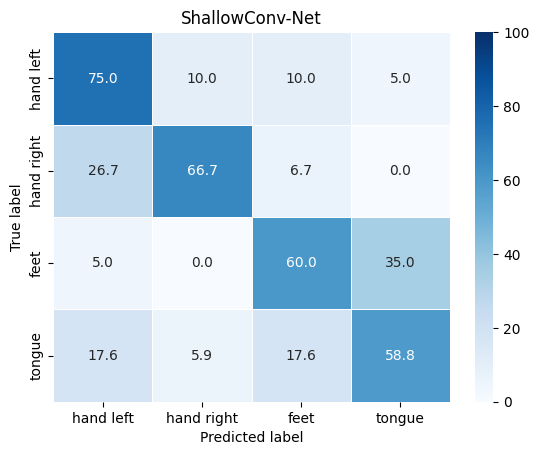

In [43]:
from matplotlib import pyplot as plt
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.utils.viz import plot_confusion_matrix

names = ['hand left', 'hand right', 'feet', 'tongue']
plt.figure(0)

plot_confusion_matrix(Y_test.argmax(axis=-1), preds, np.array(names), title='ShallowConv-Net')

In [44]:
# Saving the model for Future Inferences

model_json = model.to_json()
with open("./shallow model/model_shallowConvNet.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("./shallow model/model_shallowConvNet.h5")